# do not include in final doc

In [1]:
import json
import pickle
import sys
from typing import TypedDict
from datetime import timedelta, datetime

import matplotlib.pyplot as plt

import src.model as src_model
from src.recommender import Recommender
from src.spark.config import views
from src.spark.create_session import create_session

import warnings
import csv
import time
from datetime import datetime
from typing import TypedDict
from datetime import timedelta

import numpy as np
import pandas as pd
from scipy import stats
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank


from src.spark.config import views
from src.spark.create_session import create_session
from src.training import TrainingKwargs, train_lightfm
from src.model.base_model import BaseModel
from src.model.fm_model import FMModel

In [2]:
sys.modules['model'] = src_model

VIEWS = views("v4", filter_items=['tracks', 'artists'])
spark = create_session()

for view, file in VIEWS.items():
    df = spark.read.json(file)
    df.createOrReplaceTempView(view)

_tracks_with_artists = spark.sql(
    f"SELECT DISTINCT t.id as track_id, t.name as track_name, a.id as artist_id, a.name as artist_name "
    f"FROM tracks t join artists a on t.id_artist == a.id").toPandas()

with open("serialized/base_model.bin", mode='rb') as fp:
    base_model = pickle.load(fp)

with open("serialized/advanced_model.bin", mode='rb') as fp:
    advanced_model = pickle.load(fp)

del sys.modules['model']

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/19 23:34:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
RANDOM_SEED = 12345678

CLUSTERING_NO_REPS = 400
PLAYLIST_LENGTH = 20

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

VIEWS = views("v4")
spark = create_session()

for view, file in VIEWS.items():
    df = spark.read.json(file)
    df.createOrReplaceTempView(view)

_tracks = spark.sql(
    f"SELECT DISTINCT id, id_artist, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, popularity, EXTRACT(year from `release_date`) as release_year, speechiness, tempo, valence FROM tracks ").toPandas()
tracks = pd.concat([_tracks[['id', 'id_artist']], _tracks.drop(['id', 'id_artist'], axis=1).apply(stats.zscore)],
                   axis=1)
users = spark.sql(f"SELECT distinct user_id FROM sessions").toPandas()

d = spark.sql(
    """
    SELECT s.user_id, s.track_id, s.weight, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, popularity, EXTRACT(year from `release_date`) as release_year, speechiness, tempo, valence
    FROM (
        select user_id, track_id, sum(event_weight) as weight
        from (
            SELECT user_id, track_id, 1 as event_weight
            FROM sessions
            WHERE event_type like 'like'
            ) 
        group by user_id, track_id
    ) s
    inner join tracks t on s.track_id = t.id
    order by s.user_id, t.id
    """).toPandas()

In [5]:
dataset = Dataset()
dataset.fit(
    users=users['user_id'],
    items=tracks['id']
)
dataset.fit_partial(
    items=tracks['id'],
    item_features=tracks.drop('id', axis=1)
)
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

(interactions, weights) = dataset.build_interactions(d[['user_id', 'track_id']].apply(tuple, axis=1))
print(f"Interaction matrix: {repr(interactions)}")

(train, test) = random_train_test_split(interactions)

feature_names = tracks.drop(['id'], axis=1).columns

item_features = dataset.build_item_features(
    ((i, feature_names) for i in tracks['id']),
    normalize=False)
print(f"Item feature matrix: {repr(item_features)}")
def mean_dist_from_cluster_center(items_ids, model: LightFM, item_id_mapping: dict):
    item_indices = [item_id_mapping[i] for i in items_ids]
    coords = np.take(model.get_item_representations()[1], item_indices, axis=0)
    center = np.sum(coords, axis=0) / coords.shape[0]
    return np.average(np.apply_along_axis(lambda x: np.linalg.norm(center - x, ord=2), 1, coords))

(user_id_mapping, _, item_id_mapping, _) = dataset.mapping()

Num users: 5000, num_items 22412.
Interaction matrix: <5000x22412 sparse matrix of type '<class 'numpy.int32'>'
	with 2568078 stored elements in COOrdinate format>
Item feature matrix: <22412x22426 sparse matrix of type '<class 'numpy.float32'>'
	with 336180 stored elements in Compressed Sparse Row format>


In [6]:


print(f"0/10 done...", end="")
train_auc = auc_score(advanced_model.model, train,
                        item_features=item_features,
                        num_threads=12).mean()
print(f"\r1/10 done...", end="")
test_auc = auc_score(advanced_model.model, test,
                       train_interactions=train,
                       item_features=item_features,
                       num_threads=12).mean()
print(f"\r2/10 done...", end="")

train_precision = precision_at_k(advanced_model.model, train, k=10,
                                   item_features=item_features,
                                   num_threads=12).mean()
print(f"\r3/10 done...", end="")
test_precision = precision_at_k(advanced_model.model, test, k=10,
                                  train_interactions=train,
                                  item_features=item_features,
                                  num_threads=12).mean()
print(f"\r4/10 done...", end="")

train_recall = recall_at_k(advanced_model.model, train, k=10,
                             item_features=item_features,
                             num_threads=12).mean()
print(f"\r5/10 done...", end="")
test_recall = recall_at_k(advanced_model.model, test, k=10,
                            train_interactions=train,
                            item_features=item_features,
                            num_threads=12).mean()
print(f"\r6/10 done...", end="")

train_reciprocal_rank = reciprocal_rank(advanced_model.model, train,
                                          item_features=item_features,
                                          num_threads=12).mean()
print(f"\r7/10 done...", end="")
test_reciprocal_rank = reciprocal_rank(advanced_model.model, test,
                                         train_interactions=train,
                                         item_features=item_features,
                                         num_threads=12).mean()
print(f"\r8/10 done...", end="")

8/10 done...

In [7]:


mean_dists_fm = []
for _ in range(CLUSTERING_NO_REPS):
    try:
        no_users = np.random.randint(low=2, high=10)
        user_ids = users['user_id'].sample(no_users).tolist()
        r = advanced_model.predict_multiple(user_ids, PLAYLIST_LENGTH)
        mean_dists_fm.append(mean_dist_from_cluster_center(r, advanced_model.model, item_id_mapping))
    except ValueError as e:
        print(repr(e))
        print(user_ids)

mean_dist_fm = sum(mean_dists_fm) / CLUSTERING_NO_REPS

print(f"\r9/10 done...", end="")

mean_dists_base = []
for _ in range(CLUSTERING_NO_REPS):
    no_users = np.random.randint(low=2, high=10)        
    user_ids = users['user_id'].sample(no_users).tolist()
    r = base_model.predict_multiple(user_ids, PLAYLIST_LENGTH)
    mean_dists_base.append(mean_dist_from_cluster_center(r, advanced_model.model, item_id_mapping))


mean_dist_base = sum(mean_dists_base) / CLUSTERING_NO_REPS

print(f"\r10/10 done...")

class EvaluationResults(TypedDict):
    auc_train: float
    auc_test: float
    precision_train: float
    precision_test: float
    recall_train: float
    recall_test: float
    reciprocal_rank_train: float
    reciprocal_rank_test: float
    clustering_fm: float
    clustering_base: float
    percent_better: float
    time_elapsed: timedelta

res: EvaluationResults = {
    "auc_train": train_auc,
    "auc_test": test_auc,
    "precision_train": train_precision,
    "precision_test": test_precision,
    "recall_train": train_recall,
    "recall_test": test_recall,
    "reciprocal_rank_train": train_reciprocal_rank,
    "reciprocal_rank_test": test_reciprocal_rank,
    "clustering_fm": mean_dist_fm,
    "clustering_base": mean_dist_base,
    "percent_better": (mean_dist_base - mean_dist_fm) * 100 / mean_dist_base,
}

print(f"[{res}]")

10/10 done...
[{'auc_train': 0.93886787, 'auc_test': 0.94086456, 'precision_train': 0.36034, 'precision_test': 0.25335997, 'recall_train': 0.024037187384846385, 'recall_test': 0.0992822667427441, 'reciprocal_rank_train': 0.5467409, 'reciprocal_rank_test': 0.38122585, 'clustering_fm': 0.4514504111930728, 'clustering_base': 0.6449009677767754, 'percent_better': 29.9969400341578}]


In [12]:
res_df = pd.DataFrame.from_dict(res, orient='index',columns=['Wartość'])
res_df

,Wartość
auc_train,0.938868
auc_test,0.940865
precision_train,0.360340
precision_test,0.253360
recall_train,0.024037
recall_test,0.099282
reciprocal_rank_train,0.546741
reciprocal_rank_test,0.381226
clustering_fm,0.451450
clustering_base,0.644901


In [13]:
print(res_df.to_latex(escape=True))

\begin{tabular}{lr}
\toprule
 & Wartość \\
\midrule
auc\_train & 0.938868 \\
auc\_test & 0.940865 \\
precision\_train & 0.360340 \\
precision\_test & 0.253360 \\
recall\_train & 0.024037 \\
recall\_test & 0.099282 \\
reciprocal\_rank\_train & 0.546741 \\
reciprocal\_rank\_test & 0.381226 \\
clustering\_fm & 0.451450 \\
clustering\_base & 0.644901 \\
percent\_better & 29.996940 \\
\bottomrule
\end{tabular}


In [16]:
md_base = []
md_fm = []

for no_users in range(2, 11):
    mean_dists_fm = []
    for _ in range(CLUSTERING_NO_REPS):
        try:
            user_ids = users['user_id'].sample(no_users).tolist()
            r = advanced_model.predict_multiple(user_ids, PLAYLIST_LENGTH)
            mean_dists_fm.append(mean_dist_from_cluster_center(r, advanced_model.model, item_id_mapping))
        except ValueError as e:
            print(repr(e))
            print(user_ids)
    
    # mean_dist_fm = sum(mean_dists_fm) / CLUSTERING_NO_REPS
        
    mean_dists_base = []
    for _ in range(CLUSTERING_NO_REPS):
        user_ids = users['user_id'].sample(no_users).tolist()
        r = base_model.predict_multiple(user_ids, PLAYLIST_LENGTH)
        mean_dists_base.append(mean_dist_from_cluster_center(r, advanced_model.model, item_id_mapping))
    
    
    # mean_dist_base = sum(mean_dists_base) / CLUSTERING_NO_REPS
    
    md_base.append(mean_dists_base)
    md_fm.append(mean_dists_fm)

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

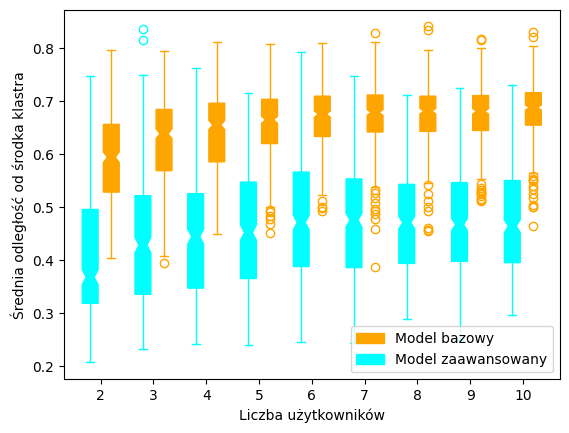

In [61]:
fig, ax = plt.subplots()
c = "orange"
bp1 = ax.boxplot(md_base, positions=np.arange(2, 11)+0.2, widths=0.3, notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
c = "cyan"
bp2 = ax.boxplot(md_fm, positions=np.arange(2, 11)-0.2, widths=0.3, notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
ax.set_xticks(range(2, 11), labels=range(2,11))
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Model bazowy', 'Model zaawansowany'], loc='best')
ax.set_xlabel("Liczba użytkowników")
ax.set_ylabel("Średnia odległość od środka klastra")
plt.show()